# Amazon Fine Food Reviews

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Hyperparameters

In [1]:
hyperparameters = {
    'limit': -1,
    'downsample_ratio': 0.25,
    'tfidf_num_features': 20000,
    'min_support': 5,
    'cv_vocab_size': 20000,
    'rf_num_trees': 10,
    'rf_max_categories': 5,
    'nb_smoothing': 0.1,
    'lr_iterations': 10, 
    'lr_regparam': 0.3,
    'lr_elastic': 0.8,
    'svm_maxIter': 10, 
    'svm_reg': 0.1
}

## Load Dataset

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, HashingTF, IDF
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

df = spark.read.csv('Reviews.csv',header=False, schema=StructType([
    StructField('Id', IntegerType(), True),
    StructField('ProductId', StringType(), True),
    StructField('UserId', StringType(), True),
    StructField('ProfileName', StringType(), True),
    StructField('HelpfulnessNumerator', IntegerType(), True),
    StructField('HelpfulnessDenominator', IntegerType(), True),
    StructField('Score', IntegerType(), True),
    StructField('Time', IntegerType(), True),
    StructField('Summary', StringType(), True),
    StructField('Text', StringType(), True)]))
if hyperparameters['limit'] > 0:
    df = df.limit(hyperparameters['limit'])
df = df.filter('Id' > 0 and length('Text') > 0).filter(col('Score') > 0).filter(col('Score') != 3)
df = df.withColumn('label', (when(col('Score') > 3, 1.0).otherwise(0)))
df = df.select('Text', 'Summary', 'label')
print df.count(), 'reviews'
df.show()

524549 reviews
+--------------------+--------------------+-----+
|                Text|             Summary|label|
+--------------------+--------------------+-----+
|I have bought sev...|Good Quality Dog ...|  1.0|
|"Product arrived ...|   Not as Advertised|  0.0|
|"This is a confec...|"""Delight"" says...|  1.0|
|If you are lookin...|      Cough Medicine|  0.0|
|Great taffy at a ...|         Great taffy|  1.0|
|I got a wild hair...|          Nice Taffy|  1.0|
|This saltwater ta...|Great!  Just as g...|  1.0|
|This taffy is so ...|Wonderful, tasty ...|  1.0|
|Right now I'm mos...|          Yay Barley|  1.0|
|This is a very he...|    Healthy Dog Food|  1.0|
|I don't know if i...|The Best Hot Sauc...|  1.0|
|One of my boys ne...|"My cats LOVE thi...|  1.0|
|My cats have been...|My Cats Are Not F...|  0.0|
|good flavor! thes...|   fresh and greasy!|  1.0|
|The Strawberry Tw...|Strawberry Twizzl...|  1.0|
|My daughter loves...|Lots of twizzlers...|  1.0|
|I love eating the...|          poo

## Preprocess

In [3]:
regexTokenizer = RegexTokenizer(inputCol='Text', outputCol='Tokenized', pattern='\\W')
add_stopwords = ['amazon', 'br', 'is', 'a', 'this', 'i', 'if', 'for', 'gp',
                 'are', 'of', 'am', 'its', 'you', 'as', 'my', 'the'] 
stopwordsRemover = StopWordsRemover(inputCol='Tokenized', 
                                    outputCol='filtered').setStopWords(add_stopwords)
regexTokenizerSummary = RegexTokenizer(inputCol='Summary', 
                                       outputCol='SummaryTokenized', pattern='\\W')
stopwordsRemoverSummary = StopWordsRemover(inputCol='SummaryTokenized', 
                                           outputCol='filteredSummary').setStopWords(add_stopwords)
df = Pipeline(stages=[regexTokenizer, stopwordsRemover, regexTokenizerSummary, 
                      stopwordsRemoverSummary]).fit(df).transform(df)
df.show()

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                Text|             Summary|label|           Tokenized|            filtered|    SummaryTokenized|     filteredSummary|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|I have bought sev...|Good Quality Dog ...|  1.0|[i, have, bought,...|[have, bought, se...|[good, quality, d...|[good, quality, d...|
|"Product arrived ...|   Not as Advertised|  0.0|[product, arrived...|[product, arrived...|[not, as, adverti...|   [not, advertised]|
|"This is a confec...|"""Delight"" says...|  1.0|[this, is, a, con...|[confection, that...|[delight, says, i...|[delight, says, i...|
|If you are lookin...|      Cough Medicine|  0.0|[if, you, are, lo...|[looking, secret,...|   [cough, medicine]|   [cough, medicine]|
|Great taffy at a ...|         Great taffy|  1.0|[great, taffy

## Investigating the Data

In [4]:
print 'min review length (in words)', df.select(min(size('Tokenized'))).collect()[0][0]
print 'max review length (in words)', df.select(max(size('Tokenized'))).collect()[0][0]
print 'average review length (in words)', df.select(mean(size('Tokenized'))).collect()[0][0]

min review length (in words) 1
max review length (in words) 2258
average review length (in words) 71.2002977796


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c7e60d0>]],
      dtype=object)

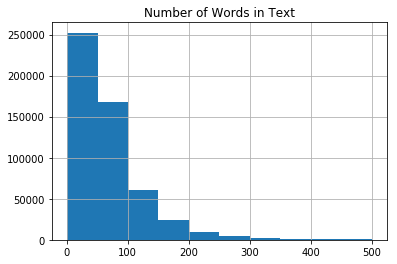

In [5]:
df.select(size('Tokenized').alias('Number of Words in Text')).toPandas().hist(range=[1, 500])

You can see that there are reviews with just one word and that there are reviews with a very high number of words but that for the most part most reviews are in the range of 50 words

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1157a02d0>]],
      dtype=object)

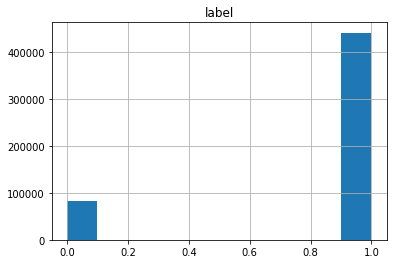

In [6]:
df.select('label').toPandas().hist(range=[0, 1])

You can see that we have a very unbalanced dataset, most of the reviews are positive

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110a5aa50>]],
      dtype=object)

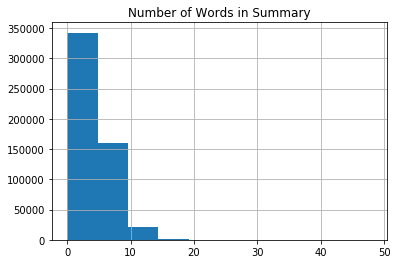

In [7]:
df.select(size('SummaryTokenized').alias('Number of Words in Summary')).toPandas().hist()

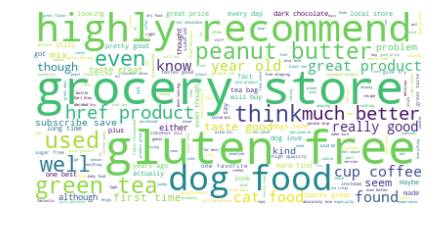

In [8]:
text = [x[0] for x in df.select('Text').collect()]
stopwords = set(STOPWORDS)
stopwords.update(['amazon', 'br', 'gp', 'though', 'although' ,'got', 'used'])
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(text))
plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Since this is a food review dataset it stands to reason that most of the words are food related and adjectives describing the experience

## Comparing the Models

In [9]:
def build_pipeline(binary):
    if binary:
        countVectors = CountVectorizer(inputCol='filtered', outputCol='features', 
                                       vocabSize=hyperparameters['cv_vocab_size'], 
                                       minDF=hyperparameters['min_support'], binary=True)
        countVectorsSummary = CountVectorizer(inputCol='filteredSummary', outputCol='featuresSummary', 
                                              vocabSize=hyperparameters['cv_vocab_size'], 
                                              minDF=hyperparameters['min_support'], binary=True)
        return Pipeline(stages=[countVectors, countVectorsSummary])
    hashingTF = HashingTF(inputCol='filtered', outputCol='rawFeatures', 
                          numFeatures=hyperparameters['tfidf_num_features'])
    idf = IDF(inputCol='rawFeatures', outputCol='features', minDocFreq=hyperparameters['min_support'])
    hashingTFSummary = HashingTF(inputCol='filteredSummary', outputCol='rawFeaturesSummary', 
                                 numFeatures=hyperparameters['tfidf_num_features'])
    idfSummary = IDF(inputCol='rawFeaturesSummary', outputCol='featuresSummary', 
                     minDocFreq=hyperparameters['min_support'])
    return Pipeline(stages=[hashingTF, hashingTFSummary, idf, idfSummary])

def evaluate(predictions, prediction_column='prediction'):
    predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select(prediction_column, 'label').collect()])
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    metrics = MulticlassMetrics(predictionAndLabels)
    print 'Precision = %s' % metrics.precision()
    print 'Recall = %s' % metrics.recall()
    print 'AUC Score = %s' % binary_metrics.areaUnderROC

## Simple Binary Vectors

In [10]:
data = build_pipeline(binary=True).fit(df).transform(df)
data.show()

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Text|             Summary|label|           Tokenized|            filtered|    SummaryTokenized|     filteredSummary|            features|     featuresSummary|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|I have bought sev...|Good Quality Dog ...|  1.0|[i, have, bought,...|[have, bought, se...|[good, quality, d...|[good, quality, d...|(20000,[0,1,2,5,1...|(10977,[1,18,19,5...|
|"Product arrived ...|   Not as Advertised|  0.0|[product, arrived...|[product, arrived...|[not, as, adverti...|   [not, advertised]|(20000,[2,9,10,25...|(10977,[6,572],[1...|
|"This is a confec...|"""Delight"" says...|  1.0|[this, is, a, con...|[confection, that...|[delight, says, i...|[delight

### Classification

In [11]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)

#### Logistic Regression

In [14]:
predictions = LogisticRegression(maxIter=hyperparameters['lr_iterations'], 
                                 regParam=hyperparameters['lr_regparam'], 
                                 elasticNetParam=hyperparameters['lr_elastic']).fit(
    trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.842241790381
Recall = 0.842241790381
AUC Score = 0.5


#### Random Forest

In [15]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(data)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', 
                               maxCategories=hyperparameters['rf_max_categories']).fit(data)
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', 
                            numTrees=hyperparameters['rf_num_trees'])
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions, 'predictedLabel')

Precision = 0.842521537337
Recall = 0.842521537337
AUC Score = 0.500886632007


#### Linear SVM

In [16]:
predictions = lsvcModel = LinearSVC(maxIter=hyperparameters['svm_maxIter'], 
                                    regParam=hyperparameters['svm_reg']).fit(
    trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.913074991258
Recall = 0.913074991258
AUC Score = 0.756072847449


#### Naive Bayes Bernoulli

In [13]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing'], 
                         modelType='bernoulli').fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.891915948755
Recall = 0.891915948755
AUC Score = 0.806314985259


#### Naive Bayes

In [12]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing']).fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.90774708332
Recall = 0.90774708332
AUC Score = 0.836118123495


### Clustering

#### K=3

In [17]:
predictions = KMeans().setK(3).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.162062498013
Recall = 0.162062498013
AUC Score = 0.461800086405


#### K=5

In [18]:
predictions = KMeans().setK(5).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.0793464093842
Recall = 0.0793464093842
AUC Score = 0.471890475402


## TF-IDF Vectors

In [19]:
data = build_pipeline(binary=False).fit(df).transform(df)
data.show()

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Text|             Summary|label|           Tokenized|            filtered|    SummaryTokenized|     filteredSummary|         rawFeatures|  rawFeaturesSummary|            features|     featuresSummary|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|I have bought sev...|Good Quality Dog ...|  1.0|[i, have, bought,...|[have, bought, se...|[good, quality, d...|[good, quality, d...|(20000,[941,1757,...|(20000,[6168,8653...|(20000,[941,1757,...|(20000,[6168,8653...|
|"Product arrived ...|   Not as Advertised|  0.0|[product, arrived...|[product, arrived...|[not, as, adverti...|   [not, adverti

### Classification

In [20]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)

#### Logistic Regression

In [22]:
predictions = LogisticRegression(maxIter=hyperparameters['lr_iterations'], 
                                 regParam=hyperparameters['lr_regparam'], 
                                 elasticNetParam=hyperparameters['lr_elastic']).fit(
    trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.842241790381
Recall = 0.842241790381
AUC Score = 0.5


#### Random Forest

In [23]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(data)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', 
                               maxCategories=hyperparameters['rf_max_categories']).fit(data)
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', 
                            numTrees=hyperparameters['rf_num_trees'])
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
predictions = pipeline.fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions, 'predictedLabel')

Precision = 0.842521537337
Recall = 0.842521537337
AUC Score = 0.500886632007


#### Linear SVM

In [24]:
predictions = lsvcModel = LinearSVC(maxIter=hyperparameters['svm_maxIter'], 
                                    regParam=hyperparameters['svm_reg']).fit(
    trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.914651746829
Recall = 0.914651746829
AUC Score = 0.76776815293


#### Naive Bayes

In [21]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing']).fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.877051212767
Recall = 0.877051212767
AUC Score = 0.837137610025


### Clustering

#### K=3

In [25]:
predictions = KMeans().setK(3).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.142562863592
Recall = 0.142562863592
AUC Score = 0.485064022137


#### K=5

In [26]:
predictions = KMeans().setK(5).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.29026289856
Recall = 0.29026289856
AUC Score = 0.482781360686
